In [1]:
sys.path.insert(0, './common')

import numpy as np
from collections import deque
import sys
import wave
import a2c_model

In [ ]:
env = wave.WaveEnv('checkpoint-velocity/Wave', 40)

In [4]:
model = a2c_model.A2C(64, 2, 512, lr=1e-4)
save_path = './results/a2c'
model.set_model_save_path(save_path)

In [ ]:
model.load_model()

In [ ]:
model.set_train_params(max_step=1000, plot_smooth=5)
model.train(env, 15, show_plot=True)

In [5]:
save_path = './results/a2c_1'
model.set_model_save_path(save_path)
model.save_model()

Training history saved


In [9]:
model.save_model('./models/a2c-alt.pth')

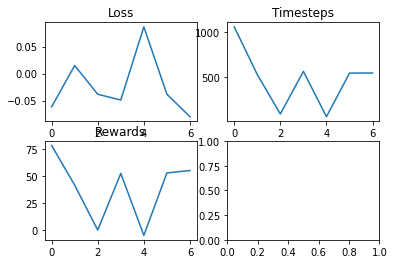

In [6]:
model.plot_train_memory(smooth=2)

In [ ]:
env = wave.WaveEnv(3)
model.test(env)

In [5]:
env.close()